In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

import warnings
warnings.filterwarnings('ignore')

#Import algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
import graphviz
from sklearn.tree import export_graphviz

import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

#Graph design preference
plt.style.use('fivethirtyeight')

In [38]:
df = pd.read_csv('responses.csv') #Loading dataset

df.head() #Shot the first 5 records in the dataset

,Timestamp,Sex:,Household Monthly Income (Php):,"Based on the Myers–Briggs Type Indicator (MBTI) test, what is your personality type?",Would you like your future college program to be related to your current track/strand?,Which track/strand are you part of?,In which specialized subject do you have the highest grade?,In which specialized subject do you have the highest grade?.1,In which specialized subject do you have the highest grade?.2,What is your specialization/strand?,In which core subject do you have the highest grade?,[Primary Skill],[Secondary Skill],Select 1 thing you'd enjoy doing the most,Select 1 thing you'd enjoy doing the most.1,Select 1 thing you'd enjoy doing the most.2,Select 1 thing you'd enjoy doing the most.3,"Which university are you planning to attend for college? (If college student, please enter your current university)","What college program are you considering to take? (If college student, please enter your current program)"
0,9/30/2024 2:57:14,Male,"Less than 9,100 to 18,200",ENFJ,Yes,TVL Track,NaN,NaN,NaN,Cookery,NaN,"Practical and Hands-On Skills (e.g., mechanica...","Creative Skills (e.g., arts and design, writin...",Physical and Health Activities,Interacting with people,Performing on stage,Cooking and presenting dishes,Un decided,BS in Culinary Arts
1,9/30/2024 2:57:14,Female,"Less than 9,100 to 18,200",ENFJ,Yes,TVL Track,NaN,NaN,NaN,Cookery,NaN,"Creative Skills (e.g., arts and design, writin...","Practical and Hands-On Skills (e.g., mechanica...",Talking/Presenting in front of people,Organizing large-scale events,Performing on stage,Cooking and presenting dishes,Earist,BS in Culinary Arts
2,10/23/2024 21:10:57,Male,"Less than 9,100 to 18,200","ENFJ (Charismatic, inspiring, and empathetic. ...",Yes,STEM,NaN,Calculus,NaN,NaN,NaN,"Technical and Analytical Skills (e.g., problem...","Practical and Hands-On Skills (e.g., mechanica...",Drawing and creating digital designs,Solving math problems,Dealing with designs of buildings/infrastructures,Reading/Writing content,University of the Philippines,BS in Mechanical Engineering
3,10/27/2024 10:47:20,Male,"18,200 to 109,200","ENFJ (Charismatic, inspiring, and empathetic. ...",Yes,TVL Track,NaN,NaN,NaN,ICT/CSS,NaN,"Collaboration and Teamwork (e.g., working in t...","Creative Skills (e.g., arts and design, writin...",Drawing and creating digital designs,Editing videos,Analyzing financial data,Studying political systems,Pup,AB in Multimedia Arts
4,10/27/2024 15:28:22,Female,"Less than 9,100 to 18,200","ENFJ (Charismatic, inspiring, and empathetic. ...",Yes,HUMSS,NaN,NaN,Disciplines and Ideas in the Applied Social Sc...,NaN,NaN,"Collaboration and Teamwork (e.g., working in t...","Leadership and Management Skills (e.g., decisi...",Physical and Health Activities,Taking care of others,Helping others learn,Dealing with human behavior,Rizal Technological University,AB in Psychology


## Data Cleaning

In [39]:
# Drop unnecessary columns
df.drop('Timestamp', axis= 1, inplace = True)
df.drop('Would you like your future college program to be related to your current track/strand?', axis= 1, inplace = True)

In [40]:
df.drop('Which university are you planning to attend for college? (If college student, please enter your current university)', axis = 1, inplace =True)

In [41]:
# Combine columns from different strands into one
df['specialized_subj'] = df['In which specialized subject do you have the highest grade?'].combine_first(df['In which specialized subject do you have the highest grade?.1']).combine_first(df['In which specialized subject do you have the highest grade?.2'])

df = df.drop(columns=['In which specialized subject do you have the highest grade?', 'In which specialized subject do you have the highest grade?.1', 'In which specialized subject do you have the highest grade?.2'])

# Rearrange the newly created column
cols = df.columns.tolist()  
cols.insert(cols.index('Which track/strand are you part of?') + 1, cols.pop(cols.index('specialized_subj')))  

df = df[cols]
df.columns

Index(['Sex:', 'Household Monthly Income (Php):',
       'Based on the Myers–Briggs Type Indicator (MBTI) test, what is your personality type? ',
       'Which track/strand are you part of?', 'specialized_subj',
       'What is your specialization/strand?',
       'In which core subject do you have the highest grade?',
       '[Primary Skill]', '[Secondary Skill]',
       'Select 1 thing you'd enjoy doing the most',
       'Select 1 thing you'd enjoy doing the most.1',
       'Select 1 thing you'd enjoy doing the most.2',
       'Select 1 thing you'd enjoy doing the most.3',
       'What college program are you considering to take? (If college student, please enter your current program)'],
      dtype='object')

In [42]:
# Fill missing data and rename columns for better readability
df.fillna("Not Applicable", inplace = True)

df.columns=['sex','income','personality','strand','specialized_subj','specialization','core_subj','p_skill','s_skill', 'interests1','interests2','interests3','interests4','program']
df.columns

Index(['sex', 'income', 'personality', 'strand', 'specialized_subj',
       'specialization', 'core_subj', 'p_skill', 's_skill', 'interests1',
       'interests2', 'interests3', 'interests4', 'program'],
      dtype='object')

## Data Normalization

In [43]:
#Normalize data by removing unnecessary spaces and texts inside parenthesis
def clean_columns(df, columns):
    for column in columns:
        df[column] = df[column].str.replace(r'\s*\(.*?\)\s*', '', regex=True)
    return df

def strip_columns(df, columns):
    for column in columns:
        df[column] = df[column].str.strip()
    return df


# Usage
columns_to_clean = ['personality', 'p_skill', 's_skill']
columns_to_strip = ['interests1', 'interests2', 'interests3' , 'interests4' ]
df = clean_columns(df, columns_to_clean)
df = strip_columns(df, columns_to_strip)


In [44]:
df.columns

Index(['sex', 'income', 'personality', 'strand', 'specialized_subj',
       'specialization', 'core_subj', 'p_skill', 's_skill', 'interests1',
       'interests2', 'interests3', 'interests4', 'program'],
      dtype='object')

## Feature Encoding

In [45]:
df_features = df.copy()

# Turn the target values into numerical in order to get the mean
le = LabelEncoder()
df_features['program_encoded'] = le.fit_transform(df_features['program'])
df_features.drop('program' , axis = 1)

,sex,income,personality,strand,specialized_subj,specialization,core_subj,p_skill,s_skill,interests1,interests2,interests3,interests4,program_encoded
0,Male,"Less than 9,100 to 18,200",ENFJ,TVL Track,Not Applicable,Cookery,Not Applicable,Practical and Hands-On Skills,Creative Skills,Physical and Health Activities,Interacting with people,Performing on stage,Cooking and presenting dishes,13
1,Female,"Less than 9,100 to 18,200",ENFJ,TVL Track,Not Applicable,Cookery,Not Applicable,Creative Skills,Practical and Hands-On Skills,Talking/Presenting in front of people,Organizing large-scale events,Performing on stage,Cooking and presenting dishes,13
2,Male,"Less than 9,100 to 18,200",ENFJ,STEM,Calculus,Not Applicable,Not Applicable,Technical and Analytical Skills,Practical and Hands-On Skills,Drawing and creating digital designs,Solving math problems,Dealing with designs of buildings/infrastructures,Reading/Writing content,20
3,Male,"18,200 to 109,200",ENFJ,TVL Track,Not Applicable,ICT/CSS,Not Applicable,Collaboration and Teamwork,Creative Skills,Drawing and creating digital designs,Editing videos,Analyzing financial data,Studying political systems,1
4,Female,"Less than 9,100 to 18,200",ENFJ,HUMSS,Disciplines and Ideas in the Applied Social Sc...,Not Applicable,Not Applicable,Collaboration and Teamwork,Leadership and Management Skills,Physical and Health Activities,Taking care of others,Helping others learn,Dealing with human behavior,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Male,"Less than 9,100 to 18,200",ISTJ,TVL Track,Not Applicable,ICT/CSS,Not Applicable,Digital Literacy,Collaboration and Teamwork,Learning things about technology,Solving math problems,Programming,Dealing with human behavior,18
180,Female,"Less than 9,100 to 18,200",ISTJ,ABM,Business Math,Not Applicable,Not Applicable,Technical and Analytical Skills,Business and Entrepreneurial Skills,Managing a business,Organizing large-scale events,Analyzing financial data,Reading/Writing content,5
181,Female,"18,200 to 109,200",ISTJ,HUMSS,"Community Engagement, Solidarity and Citizenship",Not Applicable,Not Applicable,Communication Skills,Collaboration and Teamwork,Physical and Health Activities,Interacting with people,Helping others learn,Dealing with human behavior,3
182,Female,"18,200 to 109,200",ISTP,STEM,General Biology,Not Applicable,Not Applicable,Leadership and Management Skills,Practical and Hands-On Skills,Physical and Health Activities,Taking care of others,Helping others learn,Dealing with human behavior,21


In [46]:
# Turn features from categorical to numerical using target encoding


def map_mean_encoded(df, columns, target_column):
    for column in columns:
        df[column] = df[column].map(df.groupby(column)[target_column].mean().round(3))
    return df

columns_to_map = [
    'sex', 'income', 'personality', 'strand', 'specialized_subj',
    'specialization', 'core_subj', 'p_skill', 's_skill', 
    'interests1', 'interests2', 'interests3', 'interests4'
]

df_features = map_mean_encoded(df_features, columns_to_map, 'program_encoded')


In [47]:
#Drop the column after getting the mean
df_features = df_features.drop('program_encoded', axis = 1)

## Model Training

In [48]:
# Splitting dataset
X = df_features.iloc[:, :-1]
y = df_features.iloc[:,-1]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

## Model Evaluation

In [ ]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

                               precision    recall  f1-score   support

          AB in Communication       1.00      1.00      1.00         1
        AB in Multimedia Arts       1.00      1.00      1.00         2
      AB in Political Science       0.50      1.00      0.67         1
             AB in Psychology       1.00      1.00      1.00         1
              BA in Sociology       1.00      1.00      1.00         2
            BS in Accountancy       1.00      1.00      1.00         2
           BS in Architecture       1.00      1.00      1.00         3
BS in Business Administration       1.00      1.00      1.00         1
      BS in Civil Engineering       0.00      0.00      0.00         1
   BS in Computer Engineering       0.33      1.00      0.50         1
       BS in Computer Science       0.00      0.00      0.00         1
            BS in Criminology       1.00      1.00      1.00         4
          BS in Culinary Arts       0.00      0.00      0.00         0
     

In [51]:
#get the probability
# input from the dataset

first_row_input = X_train.iloc[0:5] 

probabilities = model.predict_proba(first_row_input)

top_indices = np.argsort(probabilities[0])[::-1][:3]

top_programs = model.classes_[top_indices]
top_probabilities = probabilities[0][top_indices] * 100  

for program, prob in zip(top_programs, top_probabilities):
    print(f"{program}: {prob:.2f}%")

BS in Computer Science: 70.00%
BS in Information Technology: 16.00%
BS in Computer Engineering: 11.00%


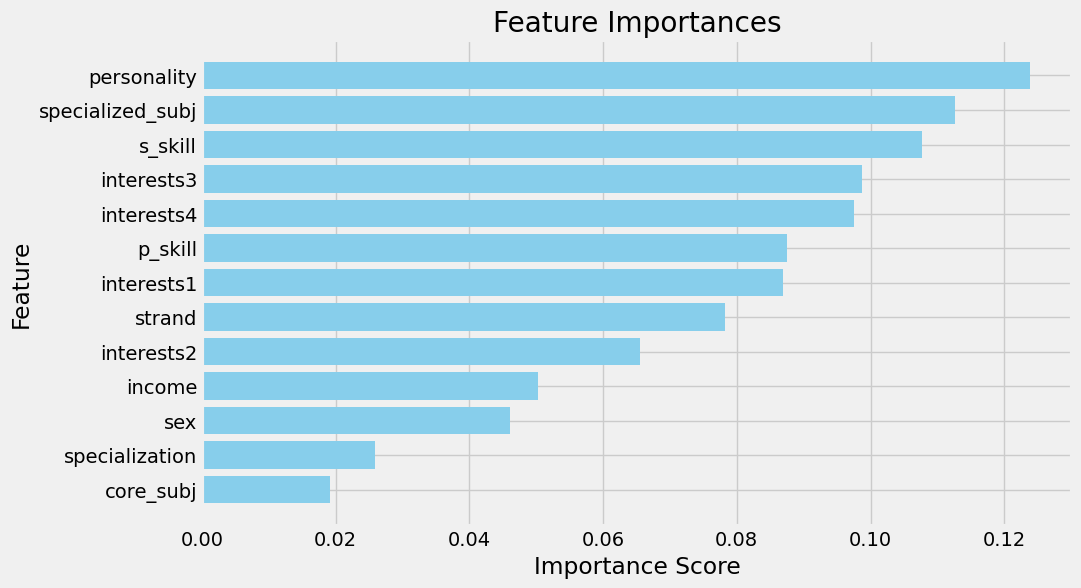

In [52]:
# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame to associate each feature with its importance score
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the most important features at the top
plt.show()


In [ ]:
with open("decision_tree_model.pkl", "wb") as file:
    pickle.dump(model, file)